In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp

BASEDIR = "/data1/shahs3/users/sunge/cnv_simulator"
DATADIR = f"{BASEDIR}/data"
BAMDIR = f"{BASEDIR}/synthetic_bams_2"

## Define paths and read in files

In [4]:
test_name = "cinner_def1_2"
group_name = ""
bin_size = 5000

# Set up figure directory
FIGDIR = f"{BAMDIR}/{test_name}/figs"
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

# Read in the CNV profile
if group_name == "":
    cnv_profile_df = pd.read_csv(f"{BAMDIR}/{test_name}/{test_name}_cell_profile.tsv", sep="\t")
else:
    cnv_profile_df = pd.read_csv(f"{BAMDIR}/{test_name}/{test_name}_{group_name}_cnv_profile.tsv", sep="\t")
cnv_profile_df["chr"] = cnv_profile_df["chr"].astype(str)


data_cnv_profile_df = cnv_profile_df.loc[cnv_profile_df["chr"] != "0"]
clone_cnv_profile_df = cnv_profile_df.loc[cnv_profile_df["chr"] == "0"]
clone_cell_count_lst = [
    len(row["cell_barcode"].split(","))
    for _, row in clone_cnv_profile_df.iloc[1:].iterrows()
]
print(f"Number of clones: {len(clone_cell_count_lst)}")
print(f"Number of cells in each clone: {clone_cell_count_lst}")

# Get centromere locations
centromere_pos = pd.read_csv(f"{DATADIR}/genome_gaps.tsv", sep = "\t")
centromere_pos = centromere_pos[centromere_pos["type"] == "centromere"]
centromere_pos["chrom"] = centromere_pos["chrom"].str.replace("chr", "")
centromere_pos = centromere_pos[["chrom", "chromStart", "chromEnd"]].reset_index(drop=True)

# Get cell barcode to index mapping
baseline_barcodes_str = cnv_profile_df[cnv_profile_df["clone"] == -1]["cell_barcode"].iloc[0]
baseline_barcodes = [x.strip() for x in baseline_barcodes_str.split(",")]
cell_idx_map= {cell_barcode: i for i, cell_barcode in enumerate(baseline_barcodes)}

# Get cell barcodes for each clone
clone_cell_id_dict = {}
clone_cell_idx_dict = {}
for _, clone in enumerate(clone_cnv_profile_df["clone"].unique()):
    if clone != -1:
        clone_cell_id_dict[f"clone{clone}"] = set(
            clone_cnv_profile_df.loc[clone_cnv_profile_df["clone"] == clone, "cell_barcode"].values[0].split(",")
        )

        clone_cell_idx_dict[f"clone{clone}"] = set(
            cell_idx_map[cb] for cb in clone_cell_id_dict[f"clone{clone}"] if cb in cell_idx_map
        ) 

# Load read depth matrix
read_depth_path = f"{BAMDIR}/{test_name}/{test_name}_final_sorted_cnv.bam.{bin_size}_read_depth.npz"
read_depth_mat = sp.load_npz(read_depth_path)
print(f"Read depth matrix shape: {read_depth_mat.shape}")

# Load bin labels
gene_windows_path = f"{DATADIR}/genome_{bin_size // 1000}kb_bins.bed"
bins = []
with open(gene_windows_path) as f:
    for line in f:
        chrom, start, end = line.strip().split()[:3]
        bins.append((chrom, int(start), int(end)))
bins = pd.DataFrame(bins, columns=["chrom", "start", "end"])




Number of clones: 11
Number of cells in each clone: [56, 52, 94, 2, 13, 26, 47, 1, 2, 6, 1]
Read depth matrix shape: (620401, 300)


## Plotting helper functions

In [19]:
copynumber_colors = {
    "0": "#2C78B2",  # Dark blue
    "1": "#94C4DB",  # Light blue
    "2": "#C5C5C5",  # Gray
    "3": "#FCC484",  # Light orange
    "4": "#FA8154",  # Orange
    "5": "#DD4031",  # Red-orange
    "6": "#A9000D",  # Dark red
    "7": "#8C033A",  # Burgundy
    "8": "#6A1B9A",  # Medium purple
    "9": "#4A148C",  # Dark purple
    "10": "#38006B",  # Very dark purple
    "11": "#2E0057",  # Deep purple
    "12": "#240043",  # Almost black purple
    "13": "#1A002F",  # Darkest purple
    "14": "#12001C",  # Near-black purple
}

def plot_true_cnv(cnv_profile_df, n_cells_per_clone, centromere_pos, save = True):
    num_clones = len(cnv_profile_df["clone"].unique())

    chr_lengths = cnv_profile_df.groupby("chr")["end"].max().sort_index()
    chr_offsets = chr_lengths.cumsum().shift(fill_value = 0).to_dict()
    chr_labels = {pos: chr for chr, pos in chr_offsets.items()}

    plot_df = cnv_profile_df.copy()
    plot_df.loc[:, "genome_start"] = plot_df.apply(
        lambda row: row["start"] + chr_offsets[row["chr"]], axis=1)
    plot_df.loc[:, "genome_end"] = plot_df.apply(
        lambda row: row["end"] + chr_offsets[row["chr"]], axis=1)

    fig, ax = plt.subplots(nrows = len(plot_df["clone"].unique()),
                        ncols = 1,
                        figsize = (10, 2 * num_clones))

    for i, clone in enumerate(plot_df["clone"].unique()):
        clone_df = plot_df[plot_df["clone"] == clone]
        for _, row in clone_df.iterrows():
            ax[i].plot(
                [row["genome_start"], row["genome_end"]],
                [row["state"], row["state"]],
                color = copynumber_colors[str(min(row["copy_number"], 14))],
                alpha=0.7,
            )
        for offset in chr_offsets.values():
            ax[i].axvline(offset, color = "grey", linestyle = "--", linewidth = 0.5)
        for _, cent_row in centromere_pos.iterrows():
            if cent_row["chrom"] not in chr_offsets:
                continue
            cent_start = cent_row["chromStart"] + chr_offsets[cent_row["chrom"]]
            cent_end = cent_row["chromEnd"] + chr_offsets[cent_row["chrom"]]
            ax[i].axvspan(cent_start, cent_end, color = "lightgrey", alpha = 0.5, label = "Centromere" if i == 0 else None)

        ax[i].set_xticks(
            ticks = list(chr_offsets.values()),
            labels = list(chr_labels.values()),
            ha = "center"
        )

        ax[i].set_ylabel("Copy number")
        ax[i].set_title(f"Clone {clone} ({n_cells_per_clone[i]} cells)")

    plt.tight_layout()
    plt.show()

    if save:
        fig.savefig(f"{FIGDIR}/true_cnv_profile.png", dpi = 300, bbox_inches = "tight")
        print(f"Saved figure to {FIGDIR}/true_cnv_profile.png")
        

def plot_read_depth_heatmap(read_depth_mat, clone_cell_idx_dict, clone_lst, bins, bin_mult, chr_lst, 
                            region_range = None, prefix = "", vmax = 100, save = True):

    clone_heatmap_data_lst = []
    row_colors = []

    clone_color_palette = sns.color_palette("tab10", n_colors = len(clone_lst))

    for clone in clone_lst:
        clone_idxs = sorted(clone_cell_idx_dict[f"clone{clone}"])
        chr_heatmap_data_lst = []
        for chr in chr_lst:
            if region_range is not None:
                chr_bin_idxs = bins[(bins["chrom"] == chr) & (bins["start"] >= region_range[0]) & (bins["end"] <= region_range[1])].index.tolist()
            else:
                chr_bin_idxs = bins[bins["chrom"] == chr].index.tolist()
            chr_heatmap_data = read_depth_mat.tocsr()[chr_bin_idxs, :][:, clone_idxs].toarray()
            nrows = chr_heatmap_data.shape[0]
            if nrows % bin_mult != 0:
                chr_heatmap_data = chr_heatmap_data[:nrows - nrows % bin_mult, :]
            chr_heatmap_data = chr_heatmap_data.reshape(-1, bin_mult, len(clone_idxs)).sum(axis = 1)
            chr_heatmap_data_lst.append(chr_heatmap_data.T)
        clone_heatmap_data = np.concatenate(chr_heatmap_data_lst, axis = 1)
        clone_heatmap_data_lst.append(clone_heatmap_data)
        row_colors.extend([clone_color_palette[int(clone)]] * clone_heatmap_data.shape[0])

    heatmap_data = np.concatenate(clone_heatmap_data_lst, axis = 0)

    chr_start_pos = []
    pos = 0
    for chr in chr_lst:
        n_bins = len(bins[bins["chrom"] == chr])
        chr_start_pos.append(pos)
        pos += n_bins // bin_mult
    
    vmax = np.percentile(heatmap_data, 99.9)* 1.3 if vmax is None else vmax
    print(vmax)

    plt.figure(figsize = (10, 5 * len(chr_lst)))
    cluster_plt = sns.clustermap(
        heatmap_data,
        cmap = "viridis",
        cbar_pos = (1.03, 0.6, 0.03, 0.2),
        cbar_kws = {"label": "Read depth"},
        row_cluster = False,
        col_cluster = False,
        dendrogram_ratio = (0.01, 0.01),
        xticklabels = False,
        yticklabels = False,
        row_colors = row_colors,
        vmax = vmax
    )
    cluster_plt.ax_heatmap.set_ylabel("Cells")
    cluster_plt.ax_heatmap.set_xlabel("Bins")
    cluster_plt.ax_heatmap.set_xticks(chr_start_pos)
    cluster_plt.ax_heatmap.set_xticklabels(chr_lst)

    for xpos in chr_start_pos:
        cluster_plt.ax_heatmap.axvline(x = xpos, color = "white", linestyle = "-", linewidth = 1)

    if save:
        fig_name = f"{prefix}read_depth_heatmap_bin{bin_size // 1000 * bin_mult}kb.png"
        plt.savefig(f"{FIGDIR}/{fig_name}", dpi = 300, bbox_inches = "tight")

    plt.show()


def plot_read_depth_scatter(read_depth_mat, clone_cell_idx_dict, clone_lst, bins, bin_mult, chr_lst,
                            region_range = None, prefix = "", save = True):

    fig, ax = plt.subplots(figsize=(10, 3 * len(clone_lst)), nrows = len(clone_lst), ncols = len(chr_lst), squeeze = False)

    for i, clone in enumerate(clone_lst):
        clone_idxs = sorted(clone_cell_idx_dict[f"clone{clone}"])
        for j, chr in enumerate(chr_lst):
            if region_range is not None:
                chr_bin_idxs = bins[(bins["chrom"] == chr) & (bins["start"] >= region_range[0]) & (bins["end"] <= region_range[1])].index.tolist()
            else:
                chr_bin_idxs = bins[bins["chrom"] == chr].index.tolist()
            chr_read_depth = read_depth_mat.tocsr()[chr_bin_idxs, :][:, clone_idxs].toarray()
            nrows = chr_read_depth.shape[0]
            if nrows % bin_mult != 0:
                chr_read_depth = chr_read_depth[:nrows - nrows % bin_mult, :]
            chr_read_depth = chr_read_depth.reshape(-1, bin_mult, len(clone_idxs)).sum(axis=1)

            mean_chr_read_depth = chr_read_depth.mean(axis = 1)
            ax[i, j].scatter(
                np.arange(len(mean_chr_read_depth)),
                mean_chr_read_depth,
                s=3
            )
            ax[i, j].set_yscale("log")
            ax[i, j].set_title(f"Clone {clone} - chr{chr}")
            ax[i, j].set_xlabel("Bins")
            ax[i, j].set_ylabel("Log(Read Depth)")
            ax[i, j].set_ylim(1, 10000)
    
    plt.tight_layout()
    plt.show()
    if save:
        fig_name = f"{prefix}norm_read_depth_scatter_bin{bin_size // 1000 * bin_mult}kb.png"
        plt.savefig(f"{FIGDIR}/{fig_name}", dpi = 300, bbox_inches = "tight")
        print(f"Saved figure to {FIGDIR}/{fig_name}")
    

def plot_read_depth_scatter_single(read_depth_mat, cell_ids, bins, bin_mult, chr_lst,
                                   prefix = "", save = True):

    fig, ax = plt.subplots(figsize=(10, 6), nrows = 1, ncols = len(chr_lst), squeeze = False)
    cell_idxs = [cell_idx_map[cell_id] for cell_id in cell_ids if cell_id in cell_idx_map]

    for j, chr in enumerate(chr_lst):
        chr_bin_idxs = bins[bins["chrom"] == chr].index.tolist()
        chr_read_depth = read_depth_mat.tocsr()[chr_bin_idxs, :][:, cell_idxs].toarray()
        nrows = chr_read_depth.shape[0]
        if nrows % bin_mult != 0:
            chr_read_depth = chr_read_depth[:nrows - nrows % bin_mult, :]
        chr_read_depth = chr_read_depth.reshape(-1, bin_mult, len(cell_idxs)).sum(axis=1)

        mean_chr_read_depth = chr_read_depth.mean(axis=1)
        ax[0, j].scatter(
            np.arange(len(mean_chr_read_depth)),
            mean_chr_read_depth,
            s=3
        )
        ax[0, j].set_yscale("log")
        ax[0, j].set_title(f"{cell_ids[0]} - chr{chr}")
        ax[0, j].set_xlabel("Bins")
        ax[0, j].set_ylabel("Log(Read Depth)")

    plt.tight_layout()
    plt.show()
    if save:
        fig_name = f"{prefix}norm_read_depth_scatter_clone{cell_ids[0]}_bin{bin_size // 1000 * bin_mult}kb.png"
        plt.savefig(f"{FIGDIR}/{fig_name}", dpi=300, bbox_inches="tight")
        print(f"Saved figure to {FIGDIR}/{fig_name}")

## Plot simulated ground-truth CNV profiles

In [6]:
data_cnv_profile_df

,clone,chr,start,end,copy_number,state,size,cell_count,cell_barcode,sample_group
12,0,2,1,93500000,2,0,93499999,56.0,"128683A-R27-C25,A96123A-R26-C64,128663A-R49-C2...","2,4,5,1,4,1,3,11,12,12,4,4,5,12,1,1,7,2,4,4,8,..."
13,0,2,93500001,242500000,3,1,148999999,56.0,"128706A-R19-C27,128724A-R53-C24,128711A-R49-C4...","1,0,6,12,8,5,9,3,10,0,11,2,0,8,11,3,9,6,0,0,10..."
14,0,2,242500001,243199373,2,0,699372,56.0,"128683A-R27-C25,A96123A-R26-C64,128663A-R49-C2...","2,4,5,1,4,1,3,11,12,12,4,4,5,12,1,1,7,2,4,4,8,..."
15,0,3,1,91000000,2,0,90999999,56.0,"128683A-R27-C25,A96123A-R26-C64,128663A-R49-C2...","2,4,5,1,4,1,3,11,12,12,4,4,5,12,1,1,7,2,4,4,8,..."
16,0,3,91000001,198022430,1,-1,107022429,56.0,"128683A-R27-C25,A96123A-R26-C64,128663A-R49-C2...","2,4,5,1,4,1,3,11,12,12,4,4,5,12,1,1,7,2,4,4,8,..."
17,1,2,1,242500000,2,0,242499999,52.0,"110720-R16-C58,128669A-R31-C18,128742A-R13-C47...","11,1,0,5,10,9,12,9,0,10,1,7,6,6,10,6,0,11,7,3,..."
18,1,2,242500001,243199373,2,0,699372,52.0,"110720-R16-C58,128669A-R31-C18,128742A-R13-C47...","11,1,0,5,10,9,12,9,0,10,1,7,6,6,10,6,0,11,7,3,..."
19,1,3,1,91000000,2,0,90999999,52.0,"110720-R16-C58,128669A-R31-C18,128742A-R13-C47...","11,1,0,5,10,9,12,9,0,10,1,7,6,6,10,6,0,11,7,3,..."
20,1,3,91000001,198022430,1,-1,107022429,52.0,"110720-R16-C58,128669A-R31-C18,128742A-R13-C47...","11,1,0,5,10,9,12,9,0,10,1,7,6,6,10,6,0,11,7,3,..."
21,2,2,1,242500000,2,0,242499999,94.0,"A96167A-R11-C49,128663A-R57-C13,128640A-R22-C1...","4,5,12,10,0,11,11,6,4,3,6,7,12,1,3,7,1,7,11,12..."


In [21]:
print(read_depth_mat.shape)

(620401, 300)


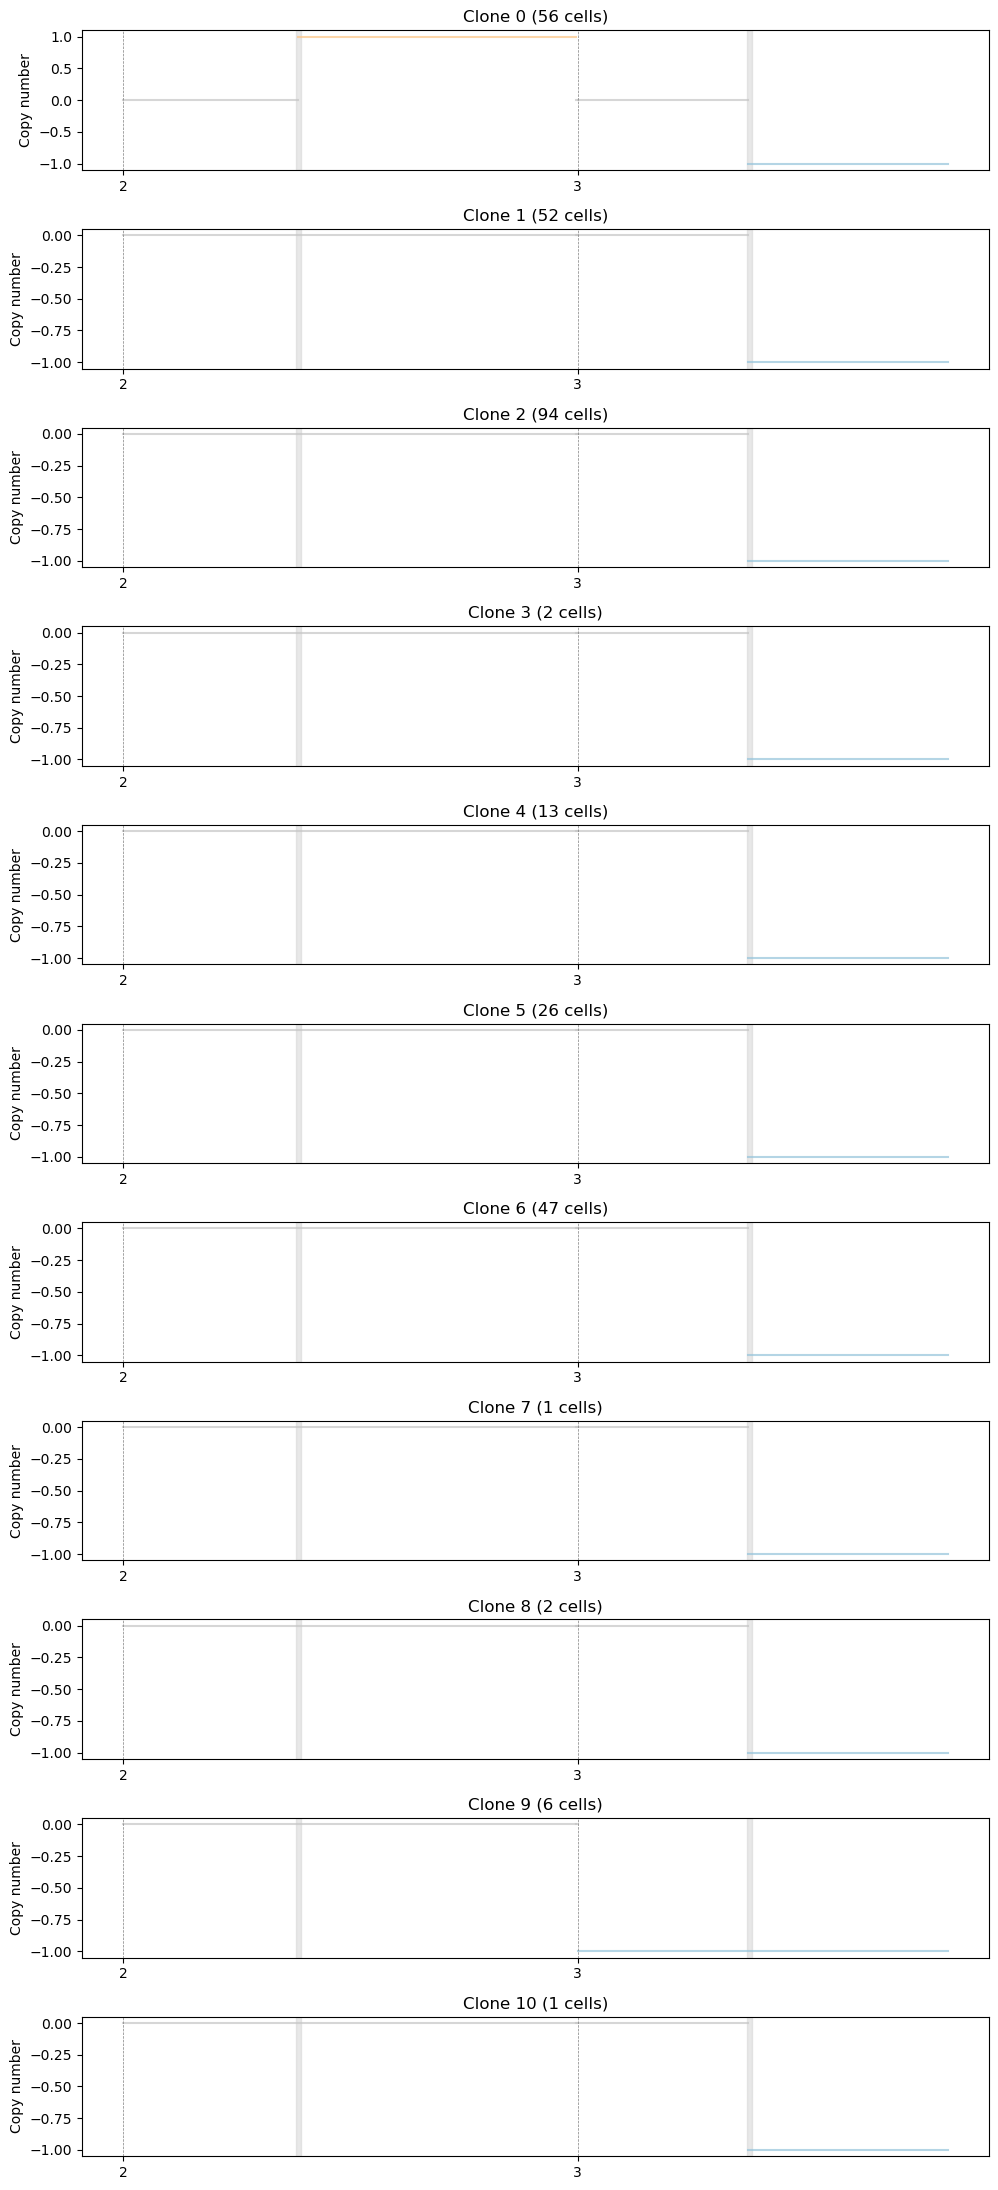

Saved figure to /data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/cinner_def1_2/figs/true_cnv_profile.png


In [7]:
plot_true_cnv(data_cnv_profile_df, clone_cell_count_lst, centromere_pos, save = True)

In [14]:
min_start = 51000001 - (bin_size * 5)
max_end = data_cnv_profile_df["end"].max() + (bin_size * 5)

print(min_start, max_end)

50975001 56525001


60


<Figure size 1000x1000 with 0 Axes>

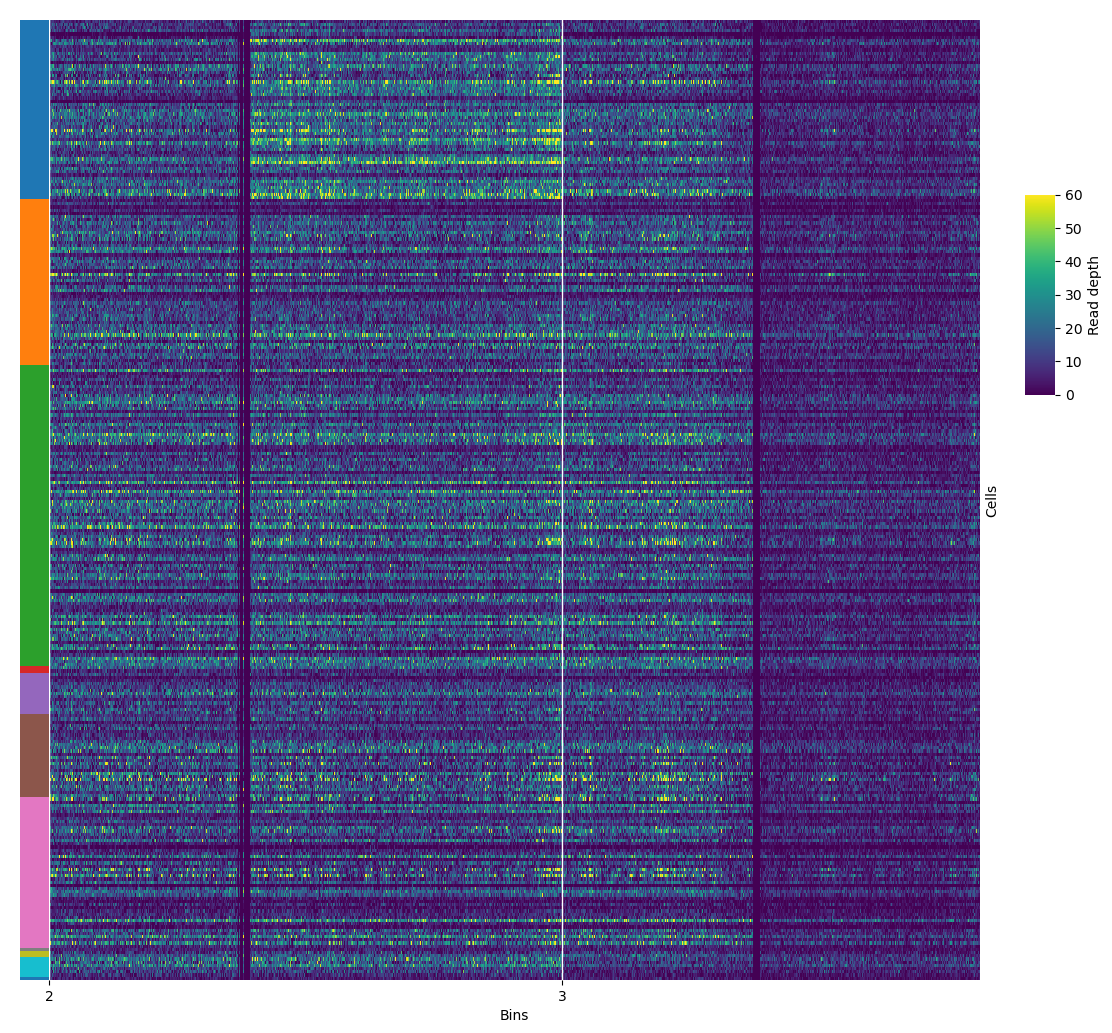

In [15]:
all_clones = data_cnv_profile_df["clone"].unique()
all_chr = data_cnv_profile_df["chr"].unique()

plot_read_depth_heatmap(
    read_depth_mat,
    clone_cell_idx_dict,
    clone_lst = all_clones,
    bins = bins,
    bin_mult = 2,
    chr_lst = all_chr,
    region_range = None,
    vmax = 60,
    save = True
)

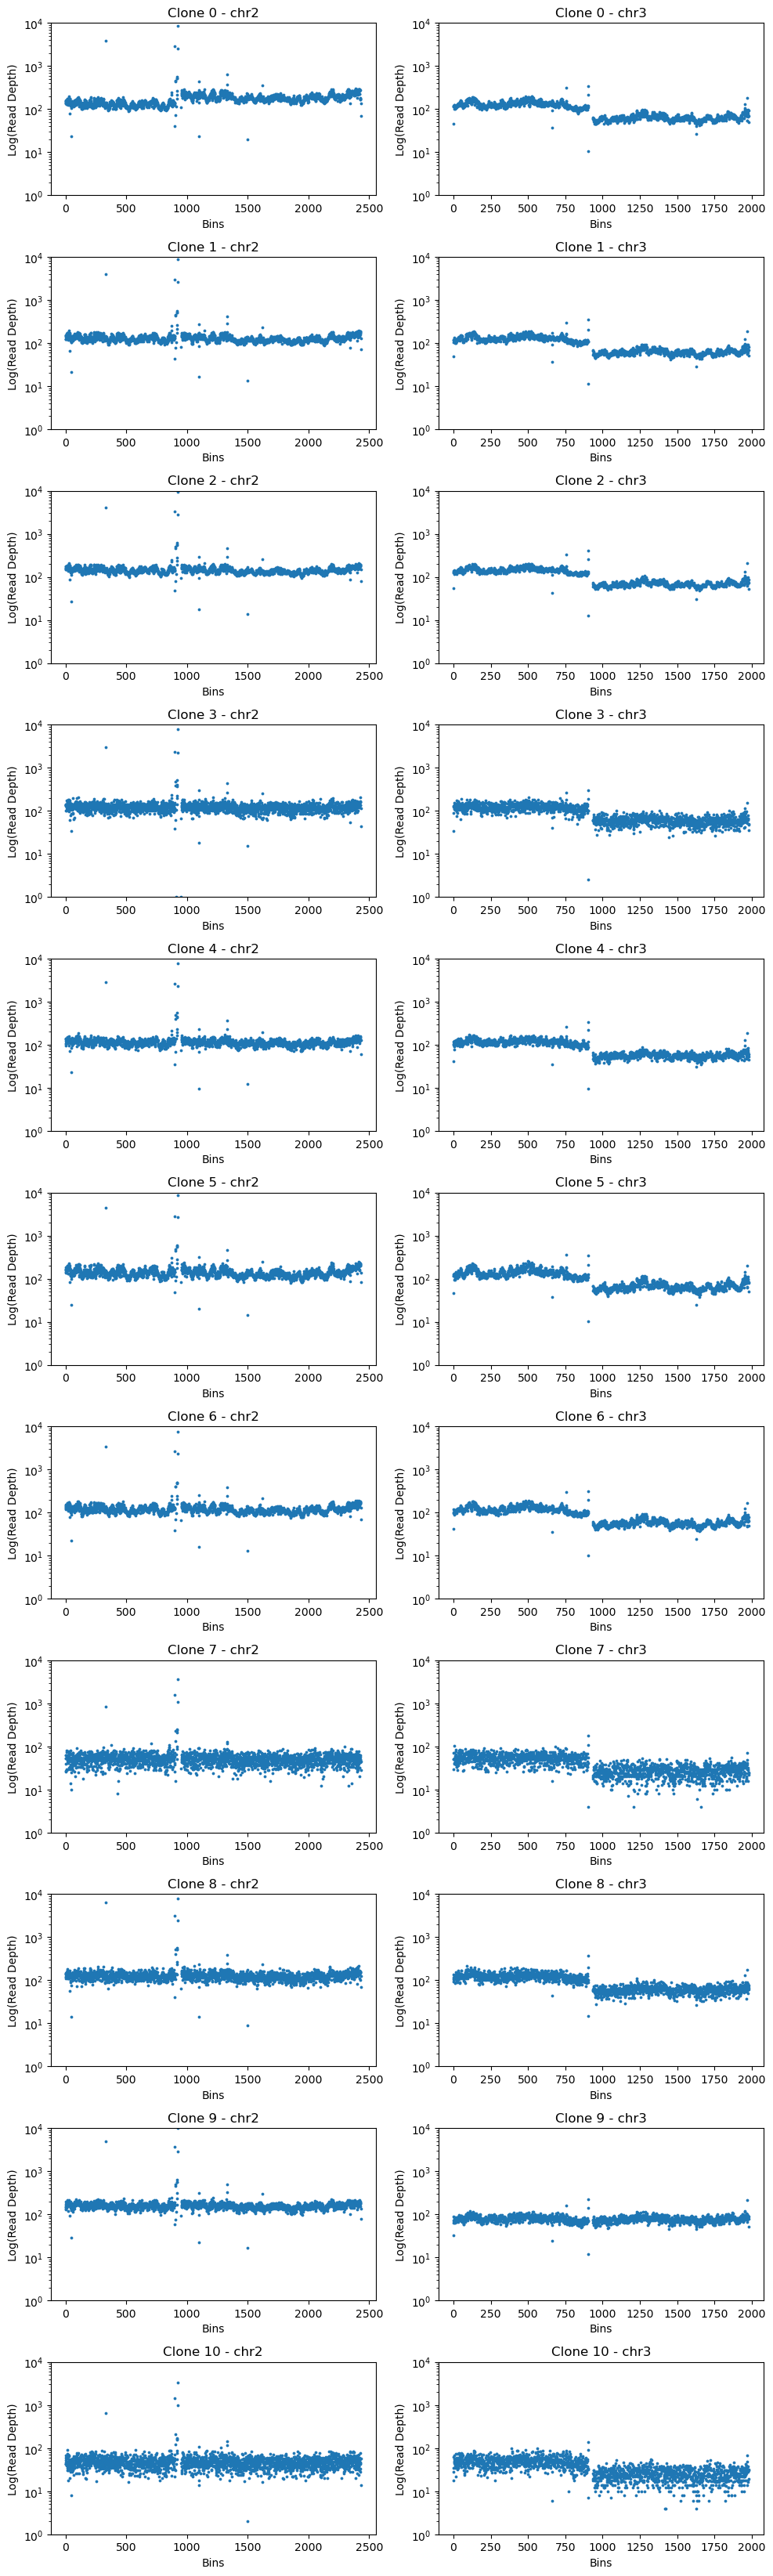

Saved figure to /data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/cinner_def1_2/figs/100kbnorm_read_depth_scatter_bin100kb.png


<Figure size 640x480 with 0 Axes>

In [20]:
plot_read_depth_scatter(
    read_depth_mat,
    clone_cell_idx_dict,
    clone_lst = all_clones,
    bins = bins,
    bin_mult = 20,
    chr_lst = all_chr,
    region_range = None,
    prefix = "100kb",
    save = True
)

{'clone0': {'128669A-R31-C18', 'A108762B-R45-C45', 'A96121B-R55-C24', 'A98245B-R60-C19', '128706A-R45-C46', '110720-R16-C59', '128624A-R22-C57', '128686A-R26-C52', 'A108762A-R27-C09', 'A108832A-R26-C51', '128640A-R56-C46', '128706A-R25-C26', '128650A-R47-C60', '128708A-R57-C23', 'A108762B-R52-C40', '128711A-R47-C31', 'A98245B-R67-C51', 'A96167A-R11-C49', '128726A-R57-C49', '110720-R24-C54'}, 'clone1': {'128665A-R42-C56', 'A108832A-R18-C42', '128729A-R20-C19', '128724A-R54-C54', 'A96167B-R56-C64', '110720-R32-C58', '128708A-R22-C43', 'A108762A-R08-C13', '128726A-R57-C55', '128706A-R19-C60'}}


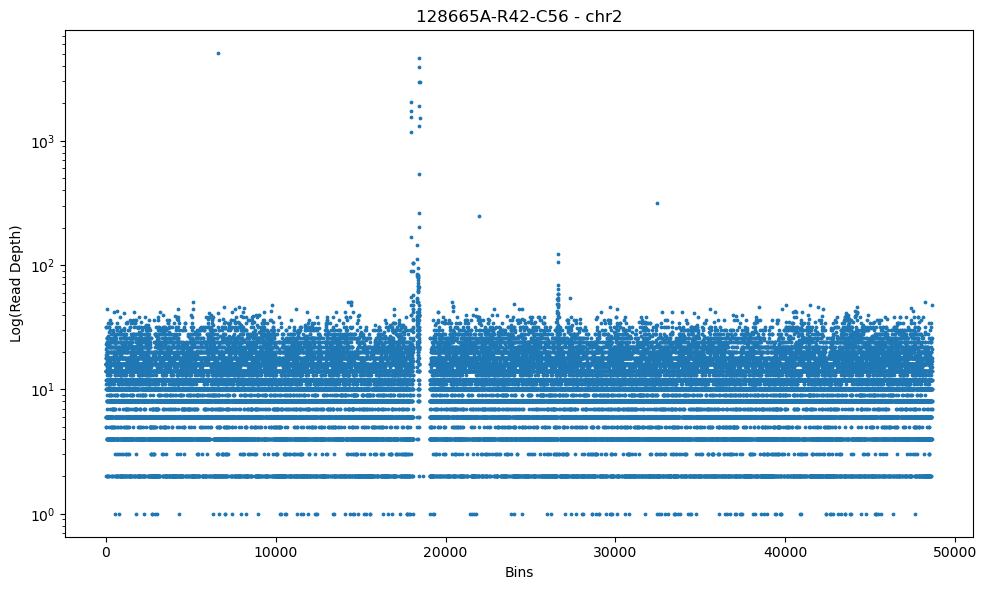

Saved figure to /data1/shahs3/users/sunge/cnv_simulator/synthetic_bams_2/minitest_c2_2/figs/norm_norm_read_depth_scatter_clone128665A-R42-C56_bin5kb.png


<Figure size 640x480 with 0 Axes>

In [25]:
print(clone_cell_id_dict)

select_cell_id = list(clone_cell_id_dict["clone1"])[0]
plot_read_depth_scatter_single(
    read_depth_mat,
    cell_ids = [select_cell_id],
    bins = bins,
    bin_mult = 1,
    chr_lst = ["2"],
    prefix = "norm_",
    save = True
)